In [1]:
import xarray as xr
import numpy as np
import functions
import matplotlib.pyplot as plt

In [2]:
datadir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'

## Regrid vertical variables to pressure levels

### Hybrid sigma coordinates at interfaces

In [3]:
savedir = datadir+'regridded_interface_last30yrs/'
exp = 'piClim'
tslice = slice('2040-01-01', '2069-12-31')
var_list = ['TH']
regrid_vars = ['hyai', 'hybi', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

var_list = ['TH']
# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure_interfaces(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyai', 'hybi', 'P0', 'PS'])
ds_slice.to_netcdf(savedir+exp+'_new.nc')

In regrid_to_pressure atf.function. Regridding TH to pressure levels


### Hybrid sigma coordinates at midpoints

In [21]:
savedir = datadir+'regridded_midpoint_last30yrs/'
exp = 'abrupt-4xCO2'
tslice = slice('2040-01-01', '2069-12-31')
#var_list = ['CLOUD', 'RELHUM', 'Q', 'T']
var_list = ['U','V','OMEGA']
regrid_vars = ['hyam', 'hybm', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyam', 'hybm', 'P0', 'PS','lev'])
print(ds_slice)
ds_slice.to_netcdf(savedir+exp+'_dyn.nc')

In regrid_to_pressure atf.function. Regridding U to pressure levels


In regrid_to_pressure atf.function. Regridding V to pressure levels
In regrid_to_pressure atf.function. Regridding OMEGA to pressure levels
<xarray.Dataset> Size: 4GB
Dimensions:  (lat: 96, lon: 144, time: 360, plev: 32)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 3kB 2040-01-15 00:00:00 ... 2069-12-15 00:00:00
  * plev     (plev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Data variables:
    U        (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>
    V        (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>
    OMEGA    (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>


## Open variables for analysis

In [3]:
filedir = datadir+'regridded_midpoint_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'.nc'
    #files = filedir+exp+'_dyn.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds = xr.concat(ds_list, dim='co2_conc')
ds = ds.assign_coords({'co2_conc':exp_list})

In [11]:
filedir = datadir+'regridded_interface_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'_new.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds_if = xr.concat(ds_list, dim='co2_conc')
ds_if = ds_if.assign_coords({'co2_conc':exp_list})

## Create regional masks

In [4]:
landmask = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landmask.isel(time=0)
oceanmask = 1-landmask

In [5]:
maskdir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
tslice = slice('2040-01-01', '2069-12-31')

ds_masks_piClim = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_20250529.camextra.concatfiles.nc')
ds_masks_4xCO2 = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529.camextra.concatfiles.nc')

# Fix time stamp
ds_masks_piClim = functions.fix_cam_time(ds_masks_piClim)
ds_masks_4xCO2 = functions.fix_cam_time(ds_masks_4xCO2)

icemask_piClim = ds_masks_piClim['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')
icemask_4xCO2 = ds_masks_4xCO2['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')

oceanmask_season = xr.broadcast(oceanmask, icemask_piClim.season)[0]
openocean_piClim = oceanmask_season - icemask_piClim
openocean_4xCO2 = oceanmask_season - icemask_4xCO2

#openocean_strict = oceanmask - icemask_strict

<xarray.DataArray ()> Size: 8B
array(178)
Coordinates:
    time     object 8B 1920-01-15 00:00:00
    season   <U3 12B 'JJA'
<xarray.DataArray 'LANDFRAC' ()> Size: 8B
array(554)
Coordinates:
    time     object 8B 1920-01-15 00:00:00


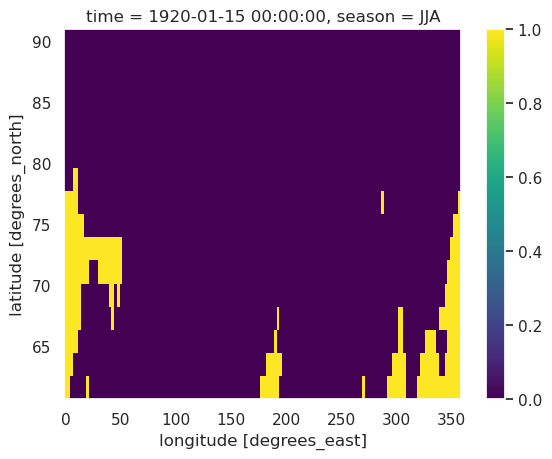

In [17]:
(openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8).plot()
print((openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8).sum())
print((landmask.sel(lat=slice(60,90), lon=slice(0,300)) > 0.8).sum())
openocean_2 = openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8
landmask_2 = landmask.sel(lat=slice(60,90)) > 0.8

## Create seasonal means

In [14]:
ds_seasons = ds.groupby('time.season').mean('time')

In [12]:
ds_if_seasons = ds_if.groupby('time.season').mean('time')

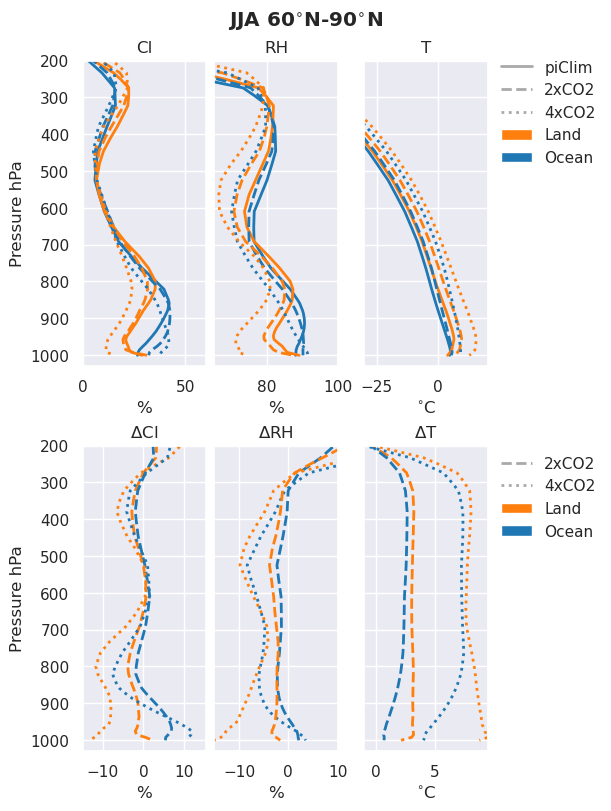

In [ ]:
import seaborn as sns
sns.set_theme()
ONLY_OPEN_OCEAN = True
EXCLUDE_GREENLAND = True
season = 'JJA'
Arctic_limit = 60
linestyles = ['-','--',':']
vars = ['CLOUD','RELHUM','T']
xlims = [[0,60], [65,100], [-30,20]]
xlims_delta = [[-15,15.5], [-15,10], [-1,9.5]]
names = ['Cl', 'RH', 'T']
units = ['%', '%', '$^{\circ}$C']

fig, axs = plt.subplots(2, 3, figsize=(6,8), sharey=True, constrained_layout=True)
fig.suptitle(season+' '+str(Arctic_limit)+'$^{\circ}$N-90$^{\circ}$N', fontweight='bold')

for i, var, xlim, xlim_delta, name, unit in zip(range(3),vars, xlims, xlims_delta, names, units):
    if EXCLUDE_GREENLAND:
        Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='piClim'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
        Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='abrupt-2xCO2'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
        Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='abrupt-4xCO2'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
    else:
        Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), landmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
    
    if ONLY_OPEN_OCEAN:
        # piClim summer > 0.8
        Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
    else:
        Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), oceanmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    d_lnd_2xCO2 = Arctic_lnd_2xCO2-Arctic_lnd_piClim
    d_ocn_2xCO2 = Arctic_ocn_2xCO2-Arctic_ocn_piClim
    d_lnd_4xCO2 = Arctic_lnd_4xCO2-Arctic_lnd_piClim
    d_ocn_4xCO2 = Arctic_ocn_4xCO2-Arctic_ocn_piClim

    if var=='T':
        axs[0][i].plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2,label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2, label='4xCO2 land')
        
        axs[1][i].plot(d_lnd_2xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot(d_ocn_2xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1], lw=2,label='2xCO2 land-ocean')
        axs[1][i].plot(d_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')
        axs[1][i].plot(d_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')


    elif var=='CLOUD':
        axs[0][i].plot((Arctic_ocn_piClim)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2,label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2], lw=2,label='4xCO2 land')
        
        axs[1][i].plot((d_lnd_2xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot((d_ocn_2xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1], lw=2,label='2xCO2 land-ocean')
        axs[1][i].plot((d_lnd_4xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')
        axs[1][i].plot((d_ocn_4xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')


    else:
        axs[0][i].plot((Arctic_ocn_piClim), ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim), ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2), ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2), ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2, label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2), ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2), ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2, label='4xCO2 land')
    
        axs[1][i].plot(d_ocn_2xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2, label='2xCO2 land-ocean')
        axs[1][i].plot(d_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')
        axs[1][i].plot(d_lnd_2xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot(d_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')


    axs[0][i].set_ylim([1030,200])
    axs[0][i].set_xlabel(unit)
    axs[0][i].set_title(name)
    axs[0][i].set_xlim(xlim)
    #axs[0][i].grid()

    axs[1][i].set_ylim([1030,200])
    axs[1][i].set_xlabel(unit)
    axs[1][i].set_title('$\Delta$'+name)
    axs[1][i].set_xlim(xlim_delta)
    #axs[1][i].grid()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements_1 = [Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[0], label='piClim'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[1], label='2xCO2'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[2], label='4xCO2'),
                   Patch(facecolor='tab:orange', label='Land'),
                   Patch(facecolor='tab:blue', label='Ocean')]

legend_elements_2 = [Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[1], label='2xCO2'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[2], label='4xCO2'),
                   Patch(facecolor='tab:orange', label='Land'),
                   Patch(facecolor='tab:blue', label='Ocean')]

axs[0][0].set_ylabel('Pressure hPa')
axs[1][0].set_ylabel('Pressure hPa')
axs[0][2].legend(handles=legend_elements_1, loc='center left', bbox_to_anchor=(1, 0.83),frameon=False)
axs[1][2].legend(handles=legend_elements_2, loc='center left', bbox_to_anchor=(1, 0.83),frameon=False)

#fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig2.png')
#fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig2.pdf')
plt.show()

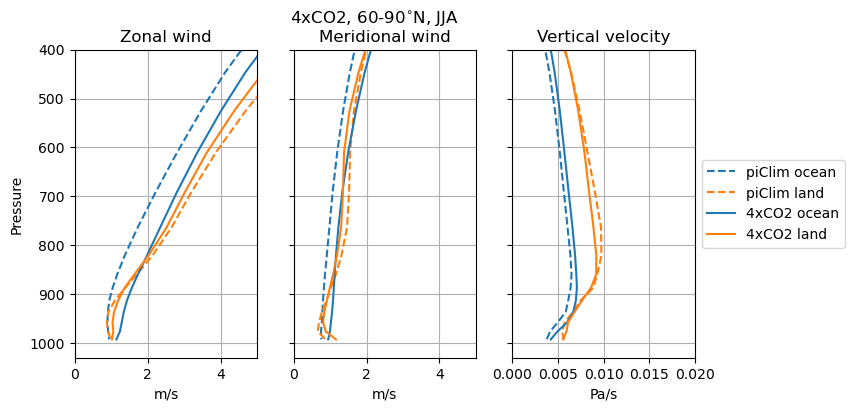

In [43]:

season = 'JJA'
co2_conc = 'abrupt-4xCO2'
Arctic_limit = 60
vars = ['U','V','OMEGA']
xlims = [[0,5], [0,5], [0,0.02]]
names = ['Zonal wind','Meridional wind','Vertical velocity']
units = ['m/s', 'm/s', 'Pa/s']

fig, axs = plt.subplots(1, 3, figsize=(8,4), sharey=True)
fig.suptitle(co2_conc.split('-')[-1]+', '+str(Arctic_limit)+'-90$^{\circ}$N, '+season)

for ax, var,xlim, name, unit in zip(axs.flatten(),vars, xlims, names, units):

    Arctic_lnd_piClim = functions.computeWeightedMeanMasked(xr.ufuncs.absolute(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim')), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(xr.ufuncs.absolute(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim')), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    Arctic_lnd_per = functions.computeWeightedMeanMasked(xr.ufuncs.absolute(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=co2_conc)), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_per = functions.computeWeightedMeanMasked(xr.ufuncs.absolute(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=co2_conc)), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    if var=='T':
        ax.plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    elif var=='Q':
        ax.plot((Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)*1000, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)*1000, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    else:
        ax.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per), ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per), ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    ax.set_ylim([1030,400])
    ax.set_xlabel(unit)
    ax.set_title(name)
    ax.set_xlim(xlim)
    ax.grid()
axs[0].set_ylabel('Pressure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### One variables, one CO2-concentration, different seasons

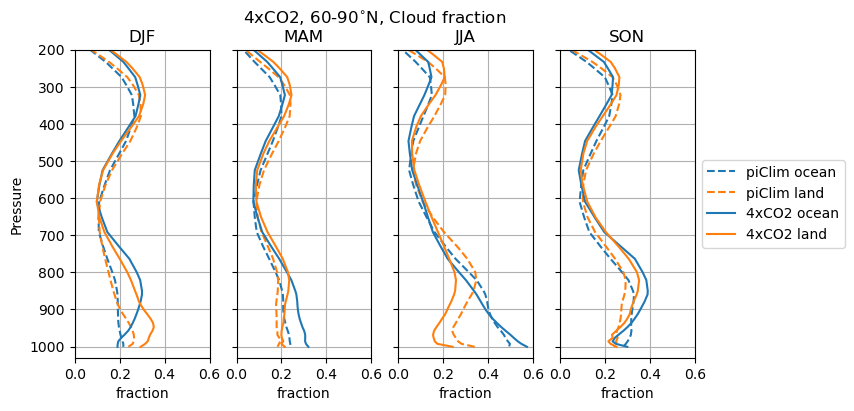

In [11]:
var = 'CLOUD'
co2_conc = 'abrupt-4xCO2'
Arctic_limit = 60
seasons = ['DJF','MAM','JJA','SON']
xlims = [[0,0.6], [0,0.6], [0,0.6], [0,0.6]]
name = 'Cloud fraction'
unit = 'fraction'

fig, axs = plt.subplots(1, 4, figsize=(8,4), sharey=True)
fig.suptitle(co2_conc.split('-')[-1]+', '+str(Arctic_limit)+'-90$^{\circ}$N, '+name)

for ax,season,xlim in zip(axs.flatten(),seasons, xlims):

    Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    Arctic_lnd_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=co2_conc), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=co2_conc), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    if var=='T':
        ax.plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    elif var=='Q':
        ax.plot((Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)*1000, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)*1000, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    else:
        ax.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per), ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per), ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    ax.set_ylim([1030,200])
    ax.set_xlabel(unit)
    ax.set_title(season)
    ax.set_xlim(xlim)
    ax.grid()
axs[0].set_ylabel('Pressure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### One season, all CO2-concentrations, different variables

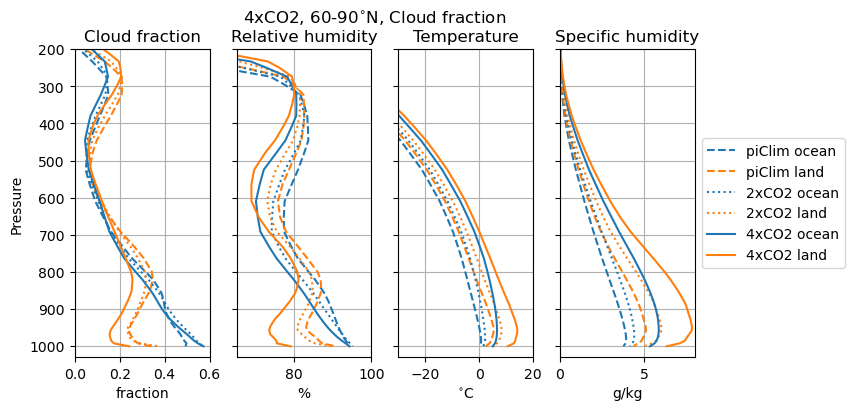

In [ ]:
season = 'JJA'
Arctic_limit = 60
vars = ['CLOUD','RELHUM','T','Q']
xlims = [[0,0.6], [65,100], [-30,20], [0,8]]
names = ['Cloud fraction', 'Relative humidity', 'Temperature', 'Specific humidity']
units = ['fraction', '%', '$^{\circ}$C', 'g/kg']

fig, axs = plt.subplots(1, 4, figsize=(8,4), sharey=True)
fig.suptitle(co2_conc.split('-')[-1]+', '+str(Arctic_limit)+'-90$^{\circ}$N')

for ax, var,xlim, name, unit in zip(axs.flatten(),vars, xlims, names, units):

    Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))


    if var=='T':
        ax.plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_2xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = ':',label='2xCO2 ocean')
        ax.plot((Arctic_lnd_2xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = ':', label='2xCO2 land')
        ax.plot((Arctic_ocn_4xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '-',label='4xCO2 ocean')
        ax.plot((Arctic_lnd_4xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '-', label='4xCO2 land')

    elif var=='Q':
        ax.plot((Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_2xCO2)*1000, ds_seasons.plev, color='tab:blue', linestyle = ':',label='2xCO2 ocean')
        ax.plot((Arctic_lnd_2xCO2)*1000, ds_seasons.plev, color='tab:orange', linestyle = ':', label='2xCO2 land')
        ax.plot((Arctic_ocn_4xCO2)*1000, ds_seasons.plev, color='tab:blue', linestyle = '-',label='4xCO2 ocean')
        ax.plot((Arctic_lnd_4xCO2)*1000, ds_seasons.plev, color='tab:orange', linestyle = '-', label='4xCO2 land')

    else:
        ax.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_2xCO2), ds_seasons.plev, color='tab:blue', linestyle = ':',label='2xCO2 ocean')
        ax.plot((Arctic_lnd_2xCO2), ds_seasons.plev, color='tab:orange', linestyle = ':', label='2xCO2 land')
        ax.plot((Arctic_ocn_4xCO2), ds_seasons.plev, color='tab:blue', linestyle = '-',label='4xCO2 ocean')
        ax.plot((Arctic_lnd_4xCO2), ds_seasons.plev, color='tab:orange', linestyle = '-', label='4xCO2 land')

    ax.set_ylim([1030,200])
    ax.set_xlabel(unit)
    ax.set_title(name)
    ax.set_xlim(xlim)
    ax.grid()
axs[0].set_ylabel('Pressure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Computing for 0.5xCO2

In [ ]:
savedir = datadir+'regridded_midpoint_last30yrs/'
exp = 'abrupt-0_5xCO2'
tslice = slice('2040-01-01', '2069-12-31')
var_list = ['CLOUD', 'RELHUM', 'Q', 'T']
regrid_vars = ['hyam', 'hybm', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyam', 'hybm', 'P0', 'PS','lev'])
print(ds_slice)

In [ ]:
filedir = datadir+'regridded_midpoint_last30yrs/'
exp = 'piClim'
files = filedir+exp+'.nc'
ds_i = xr.open_dataset(files)

In [ ]:
ds_seasons=ds_slice.groupby('time.season').mean('time')
ds_seasons_piClim = ds_i.groupby('time.season').mean('time')

In [ ]:
var = 'CLOUD'; name = 'Cloud fraction'; unit = 'fraction'
var = 'T'; name = 'Temperature'; unit = 'K'
var = 'Q'; name = 'Specific humidity'; unit = 'g/kg'
var = 'RELHUM'; name = 'Relative humidity'; unit = '%'
co2_conc = 'abrupt-0.5xCO2'
Arctic_limit = 60
seasons = ['DJF','MAM','JJA','SON']
xlims = [[-0.2,0.2], [-0.2,0.2], [-0.2,0.2], [-0.2,0.2]]

fig, axs = plt.subplots(1, 4, figsize=(8,4), sharey=True)
fig.suptitle(co2_conc.split('-')[-1]+', '+str(Arctic_limit)+'-90$^{\circ}$N, '+name)

for ax,season,xlim in zip(axs.flatten(),seasons, xlims):

    #Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons_piClim[var].sel(lat=slice(Arctic_limit, 90), season=season), landmask.sel(lat=slice(Arctic_limit, 90)))
    #Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons_piClim[var].sel(lat=slice(Arctic_limit, 90), season=season), oceanmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_piClim = functions.computeWeightedMean(ds_seasons_piClim[var].sel(lat=slice(Arctic_limit, 90), season=season))

    #Arctic_lnd_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season), landmask.sel(lat=slice(Arctic_limit, 90)))
    #Arctic_ocn_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season), oceanmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_per = functions.computeWeightedMean(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season))

    if var=='Q':
        #ax.plot((Arctic_ocn_per-Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='Ocean')
        #ax.plot((Arctic_lnd_per-Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='Land')
        ax.plot(Arctic_per-Arctic_piClim*1000, ds_seasons.plev, color='black', linestyle = '--')

    else:
        #ax.plot(Arctic_ocn_per-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='Ocean')
        #ax.plot(Arctic_lnd_per-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='Land')
        ax.plot(Arctic_per-Arctic_piClim, ds_seasons.plev, color='black', linestyle = '--')

    ax.set_ylim([1030,200])
    ax.set_xlabel(unit)
    ax.set_title(season)
    #ax.set_xlim(xlim)
    ax.grid()
axs[0].set_ylabel('Pressure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
season = 'SON'
co2_conc = 'abrupt-0.5xCO2'
Arctic_limit = 60
vars = ['CLOUD','RELHUM','T','Q']
xlims = [[0,0.6], [65,100], [-30,20], [0,8]]
names = ['Cloud fraction', 'Relative humidity', 'Temperature', 'Specific humidity']
units = ['fraction', '%', '$^{\circ}$C', 'g/kg']

fig, axs = plt.subplots(1, 4, figsize=(8,4), sharey=True)
fig.suptitle(co2_conc.split('-')[-1]+', '+str(Arctic_limit)+'-90$^{\circ}$N, '+season)

for ax, var,xlim, name, unit in zip(axs.flatten(),vars, xlims, names, units):

    Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons_piClim[var].sel(lat=slice(Arctic_limit, 90), season=season), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons_piClim[var].sel(lat=slice(Arctic_limit, 90), season=season), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    Arctic_lnd_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season), landmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_per = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    if var=='T':
        ax.plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)-273.15, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)-273.15, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    elif var=='Q':
        ax.plot((Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot((Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per)*1000, ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per)*1000, ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    else:
        ax.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='piClim ocean')
        ax.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='piClim land')
        ax.plot((Arctic_ocn_per), ds_seasons.plev, color='tab:blue', linestyle = '-',label=co2_conc.split('-')[-1]+' ocean')
        ax.plot((Arctic_lnd_per), ds_seasons.plev, color='tab:orange', linestyle = '-', label=co2_conc.split('-')[-1]+' land')

    ax.set_ylim([1030,200])
    ax.set_xlabel(unit)
    ax.set_title(name)
    #ax.set_xlim(xlim)
    ax.grid()
axs[0].set_ylabel('Pressure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

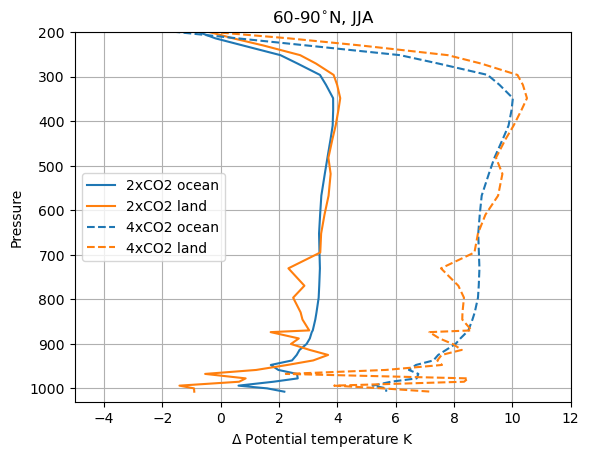

In [19]:
var = 'TH'
season = 'JJA'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot((Arctic_ocn_2xCO2-Arctic_ocn_piClim), ds_if_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot((Arctic_lnd_2xCO2-Arctic_lnd_piClim), ds_if_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot((Arctic_ocn_4xCO2-Arctic_ocn_piClim), ds_if_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot((Arctic_lnd_4xCO2-Arctic_lnd_piClim), ds_if_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Potential temperature K')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-5, 12])
plt.grid()
plt.show()


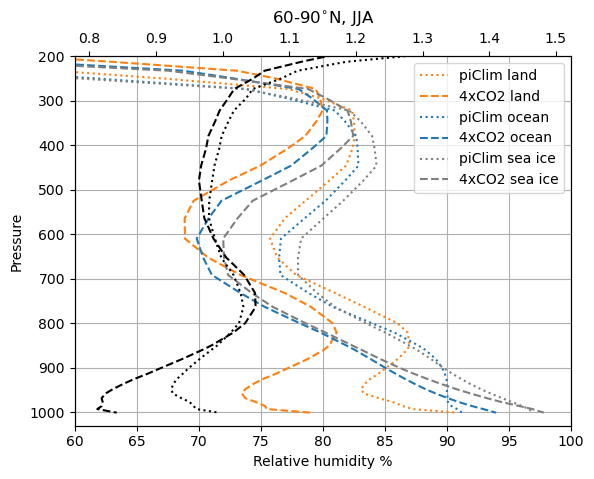

In [18]:
var = 'RELHUM'
season = 'JJA'
Arctic_limit = 60
ice_ocn_divide = True

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))

if ice_ocn_divide:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), openocean_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), icemask_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), openocean_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), icemask_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
else:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))

plt.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')
plt.plot(Arctic_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
if ice_ocn_divide:
    plt.plot(Arctic_ice_piClim, ds_seasons.plev, color='tab:grey', linestyle = ':',label='piClim sea ice')
    plt.plot(Arctic_ice_4xCO2, ds_seasons.plev, color='tab:grey', linestyle = '--',label='4xCO2 sea ice')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Relative humidity %')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([60, 100])
plt.grid()

ax2 = plt.gca().twiny()
ax2.plot(Arctic_lnd_piClim/Arctic_ocn_piClim, ds_seasons.plev, color='black', linestyle = ':',label='piClim land/ocean')
ax2.plot(Arctic_lnd_4xCO2/Arctic_ocn_4xCO2, ds_seasons.plev, color='black', linestyle = '--',label='4xCO2 land/ocean')

plt.show()

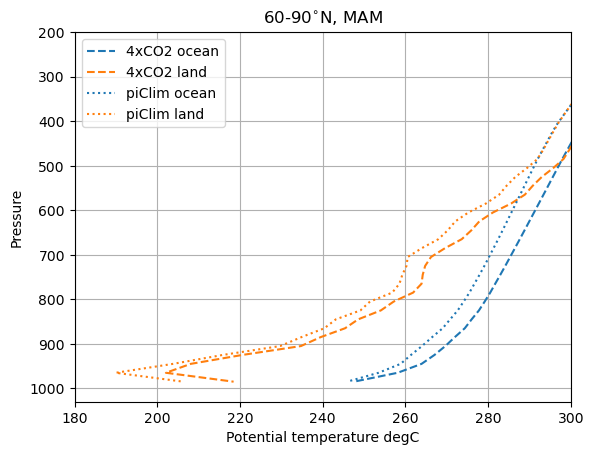

In [22]:
var = 'TH'
season = 'MAM'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2, ds_if_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2, ds_if_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_if_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim, ds_if_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Potential temperature degC')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([180, 300])
plt.grid()
plt.show()

### Compute d(TH)/dz

In [ ]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
ds_piClim = xr.open_dataset(rpath+'N1850_f19_tn14_noresm2_3_slf_output_20250529.concld.cam.concatfiles.nc')
ds_0_5xCO2 = xr.open_dataset(rpath+'N1850_f19_tn14_noresm2_3_slf_output_0_5xCO2_20250529.concld.cam.concatfiles.nc')
ds_2xCO2 = xr.open_dataset(rpath+'N1850_f19_tn14_noresm2_3_slf_output_2xCO2_20250529.concld.cam.concatfiles.nc')
ds_4xCO2 = xr.open_dataset(rpath+'N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529.concld.cam.concatfiles.nc')

In [8]:
savedir = datadir+'regridded_midpoint_last30yrs/'
tslice = slice('2040-01-01', '2069-12-31')

for ds, exp_name in zip([ds_piClim, ds_2xCO2, ds_4xCO2], ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']):
    ds_i = ds

    ds_slice = ds_i.sel(time=tslice)

    # Regrid timesliced data
    var='CONCLD'
    var_da = functions.regrid_to_pressure(ds_slice,var)
    ds_slice[var] = var_da[var]

    ds_slice = ds_slice.drop_vars(['hyam', 'hybm', 'P0', 'PS'])
    ds_slice.to_netcdf(savedir+'CONCLD_'+exp_name+'.nc')

In regrid_to_pressure atf.function. Regridding CONCLD to pressure levels
In regrid_to_pressure atf.function. Regridding CONCLD to pressure levels
In regrid_to_pressure atf.function. Regridding CONCLD to pressure levels


In [7]:
filedir = datadir+'regridded_midpoint_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+'CONCLD_'+exp+'.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds = xr.concat(ds_list, dim='co2_conc')
ds = ds.drop_vars(['hyai', 'hybi', 'time_bnds'])

In [8]:
ds_seasons = ds.groupby('time.season').mean('time')

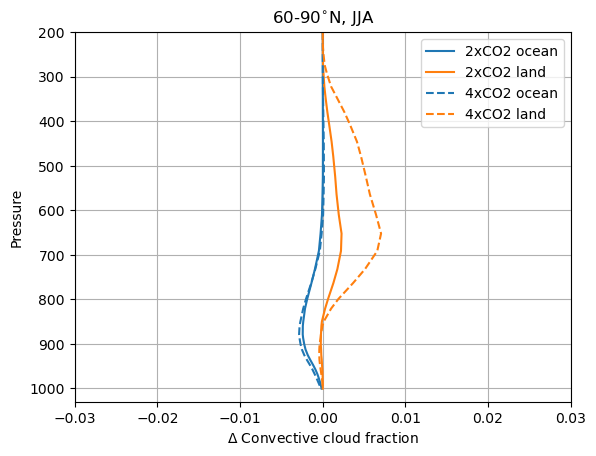

In [16]:
var = 'CONCLD'
season = 'JJA'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_2xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot(Arctic_lnd_2xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot(Arctic_ocn_4xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Convective cloud fraction')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-0.03, 0.03])
plt.grid()
plt.show()

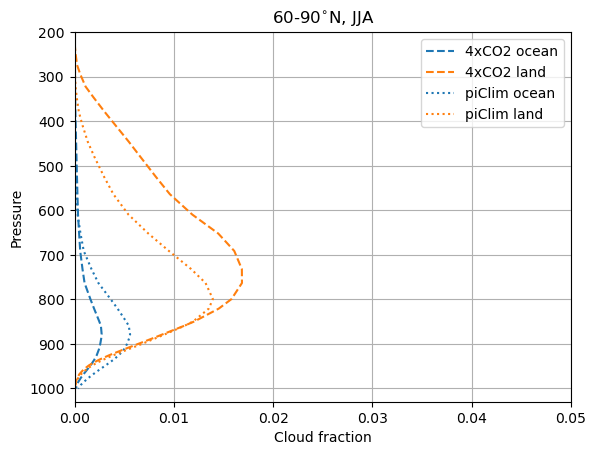

In [10]:
var = 'CONCLD'
season = 'JJA'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Cloud fraction')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([0, 0.05])
plt.grid()
plt.show()

In [ ]:
rpath= '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
ds_piClim_RH = xr.open_dataset(rpath+'RELHUM_piClim.nc')
ds_4xCO2_RH = xr.open_dataset(rpath+'RELHUM_abrupt-4xCO2.nc')
lev = ds_piClim_RH.lev[-1]
var = 'RELHUM'
tslice = slice('2040-01-01', '2069-12-31')
lim = 30
unit = 'Surface relative humidity, %'
levels=np.linspace(-lim, lim, 21)

piClim_s =ds_piClim_RH.sel(lev=lev, time=tslice).groupby('time.season').mean('time')
ds_s = ds_4xCO2_RH.sel(lev=lev, time=tslice).groupby('time.season').mean('time')

Text(0.5, 0, 'Surface relative humidity, %')

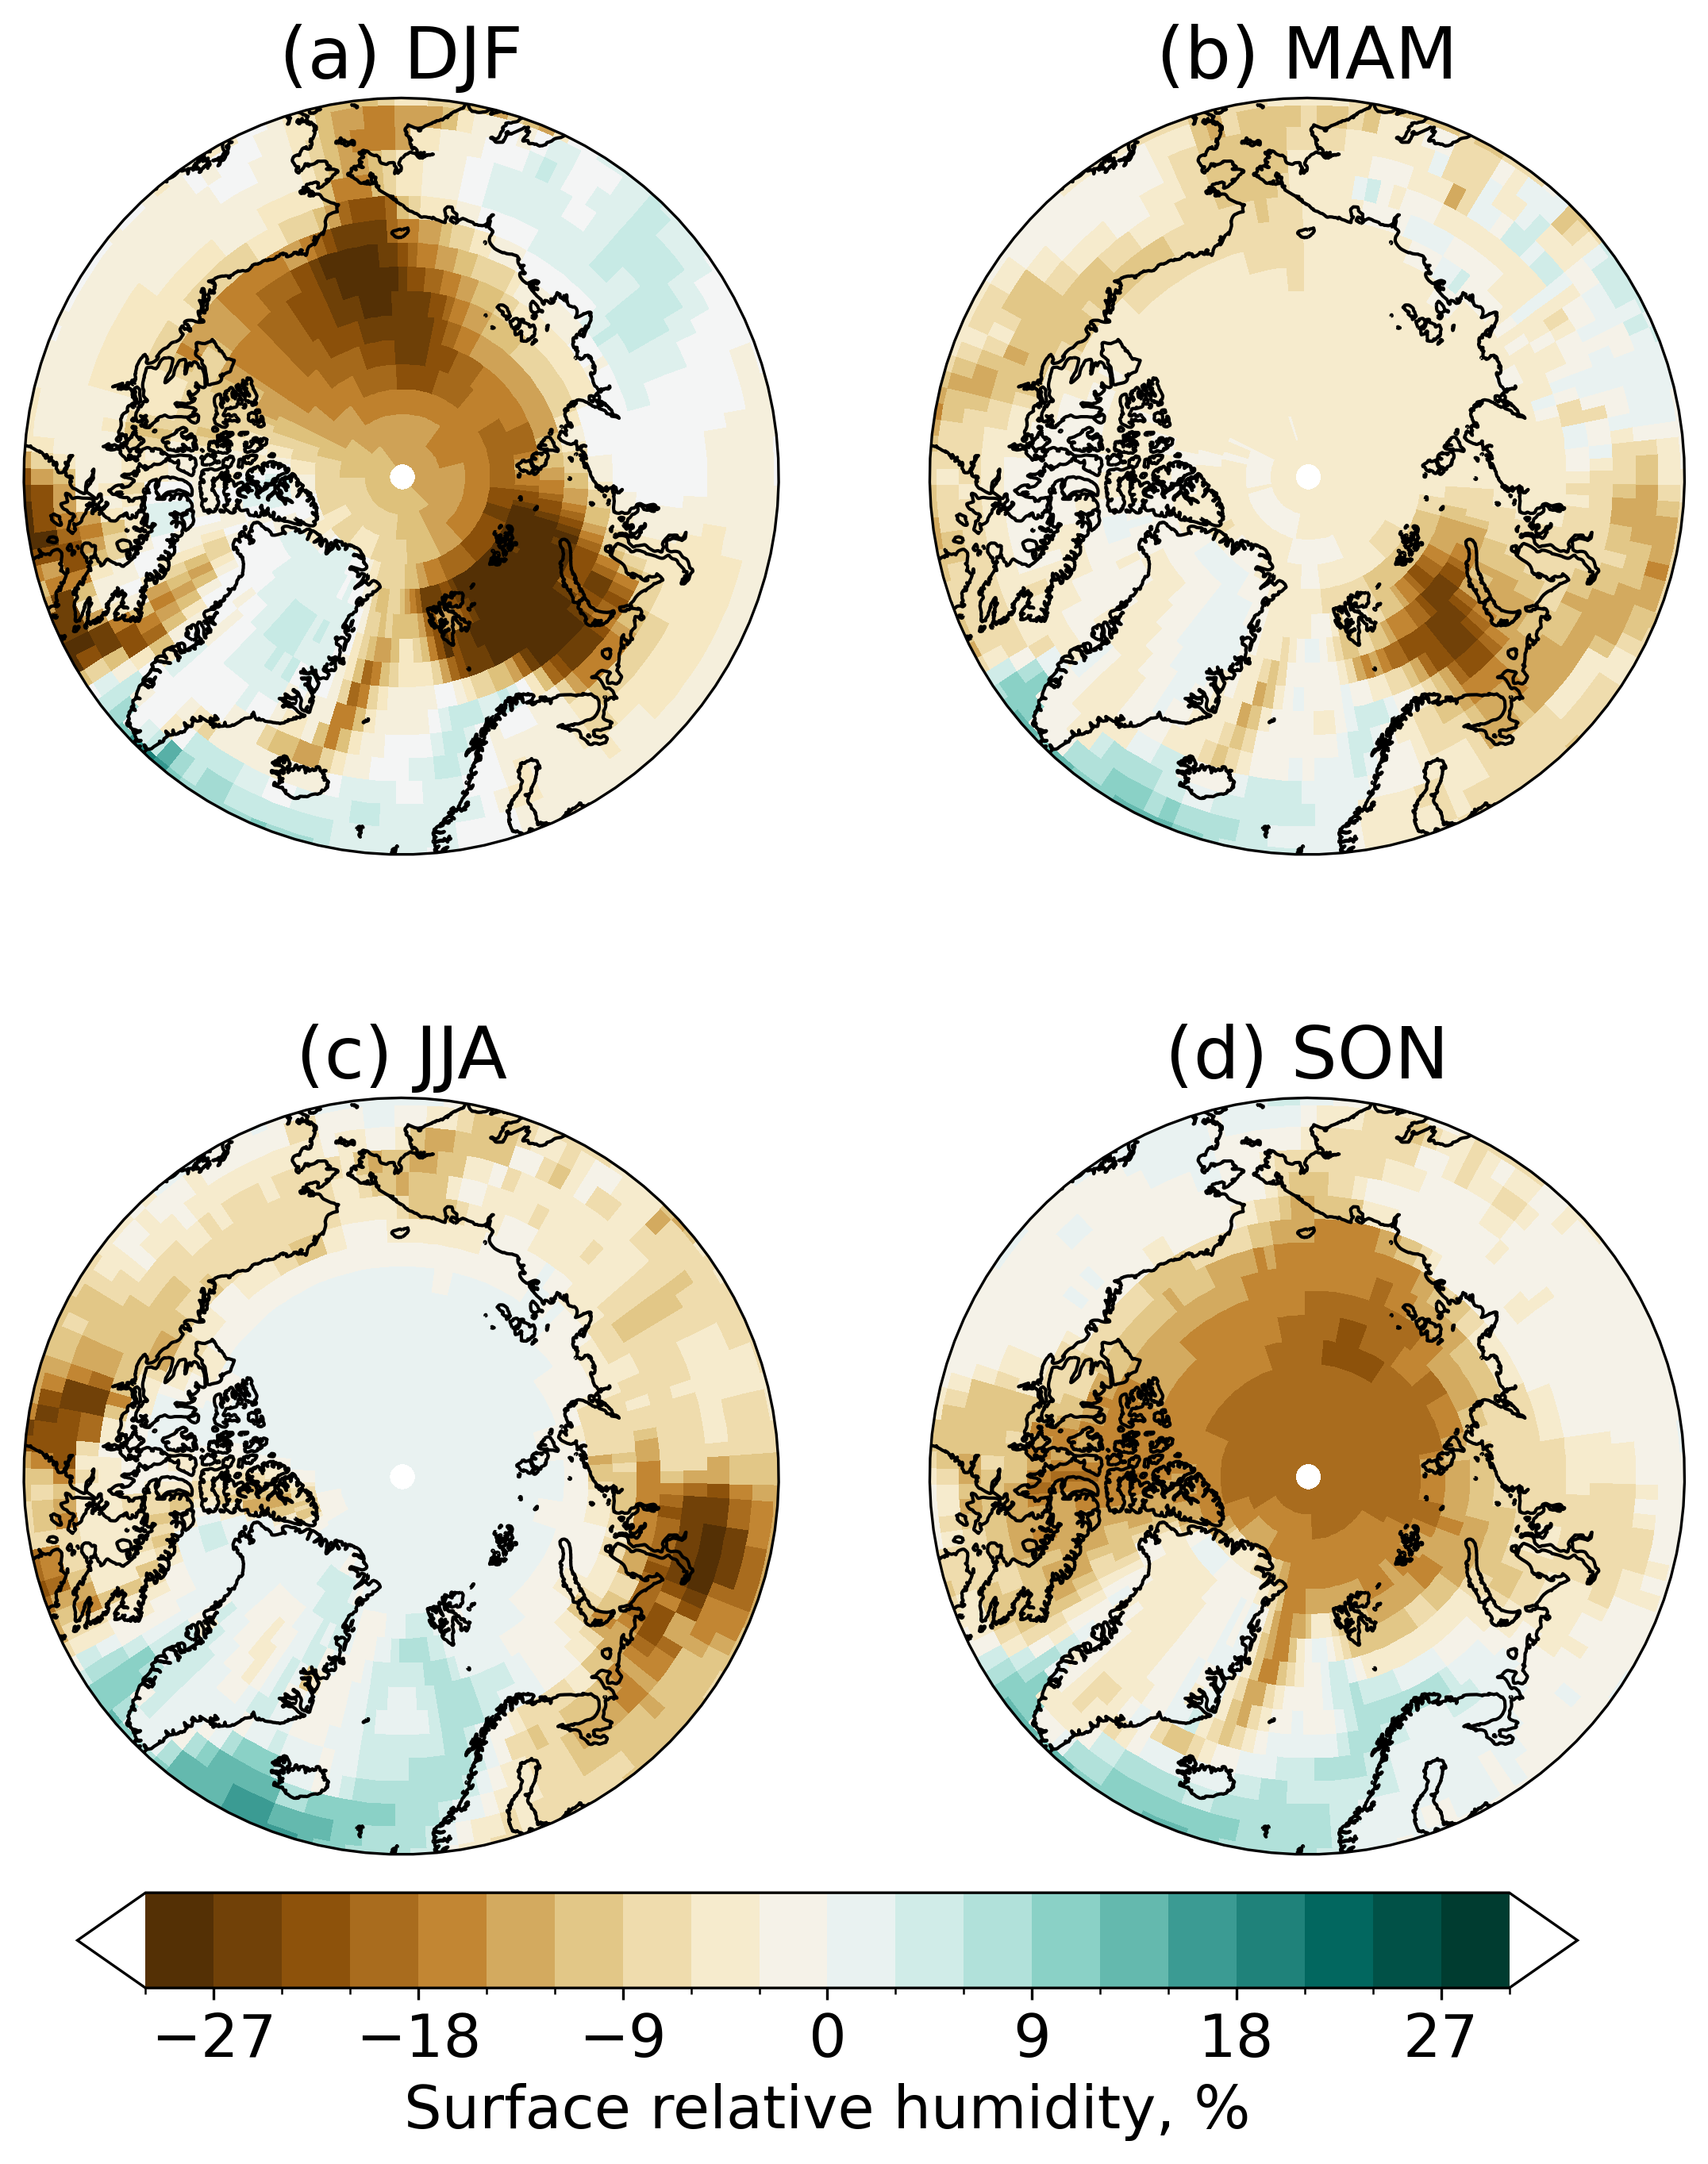

In [ ]:
rpath= '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
ds_piClim_RH = xr.open_dataset(rpath+'RELHUM_piClim.nc')
ds_4xCO2_RH = xr.open_dataset(rpath+'RELHUM_abrupt-4xCO2.nc')
lev = ds_piClim_RH.lev[-1]
var = 'RELHUM'
tslice = slice('2040-01-01', '2069-12-31')
lim = 30
unit = 'Surface relative humidity, %'
levels=np.linspace(-lim, lim, 21)

piClim_s =ds_piClim_RH.sel(lev=lev, time=tslice).groupby('time.season').mean('time')
ds_s = ds_4xCO2_RH.sel(lev=lev, time=tslice).groupby('time.season').mean('time')


import cartopy.crs as ccrs
fig = plt.figure(2, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))
#plt.subplots_adjust(top=0.85)

for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):

    functions.polarCentral_set_latlim([60,90], ax)
    data = ds_s[var].sel(season=season) - piClim_s[var].sel(season=season)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    ax.set_title(label+" "+season, fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel(unit, fontsize=18)
